# Daten importieren

In [1]:
import pandas as pd

coordinates = pd.read_csv("san_francisco_real_estate_coordinates.csv")
coordinates

,latitude,longitude
0,37.769345,-122.399423
1,37.743514,-122.419706
2,37.745989,-122.398551
3,37.754005,-122.398455
4,37.748250,-122.401119
...,...,...
1991,37.771632,-122.400836
1992,37.773497,-122.424971
1993,37.742438,-122.418571
1994,37.739873,-122.418990


In [2]:
coordinates.isnull().sum() / len(coordinates)

latitude     0.002004
longitude    0.001503
dtype: float64

# Daten aufteilen

In [3]:
from sklearn.model_selection import train_test_split

train_coordinates, test_coordinates = train_test_split(coordinates, test_size=0.2, random_state=0)

train_coordinates

,latitude,longitude
743,37.768299,-122.402863
159,37.739622,-122.419379
1165,37.774024,-122.401898
318,37.766098,-122.399665
924,37.750598,-122.398895
...,...,...
835,37.773279,-122.393901
1216,37.730334,-122.403531
1653,37.743014,-122.420489
559,37.730594,-122.398259


In [4]:
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy="mean")
num_columns = ["latitude", "longitude"]

imputed_train_coordinates = pd.DataFrame(num_imputer.fit_transform(train_coordinates[num_columns]), columns=num_columns, index=train_coordinates.index)
imputed_test_coordinates = pd.DataFrame(num_imputer.transform(test_coordinates[num_columns]), columns=num_columns, index=test_coordinates.index)

# Daten visualisieren

<Axes: xlabel='latitude', ylabel='longitude'>

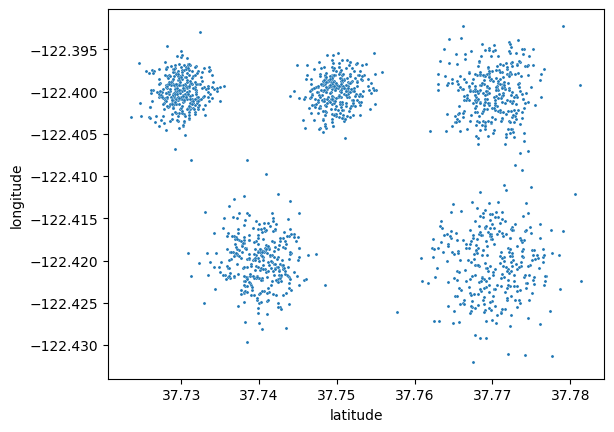

In [5]:
import seaborn as sns

sns.scatterplot(x=imputed_train_coordinates["latitude"], y=imputed_train_coordinates["longitude"], s=5)

# K-Means Clustering

In [6]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

kmeans = KMeans(n_clusters=5, random_state=0)

clustered_train_coordinates = pd.DataFrame(kmeans.fit_predict(imputed_train_coordinates).reshape(-1, 1), columns=["Cluster"], index=train_coordinates.index)
clustered_test_coordinates = pd.DataFrame(kmeans.predict(imputed_test_coordinates).reshape(-1, 1), columns=["Cluster"], index=test_coordinates.index)

clustered_train_coordinates

,Cluster
743,0
159,3
1165,0
318,0
924,4
...,...
835,0
1216,1
1653,3
559,1


In [7]:
kmeans.fit_predict(imputed_train_coordinates).reshape(-1, 1)

array([[0],
       [3],
       [0],
       ...,
       [3],
       [1],
       [3]], dtype=int32)

# Cluster visualisieren

<Axes: xlabel='latitude', ylabel='longitude'>

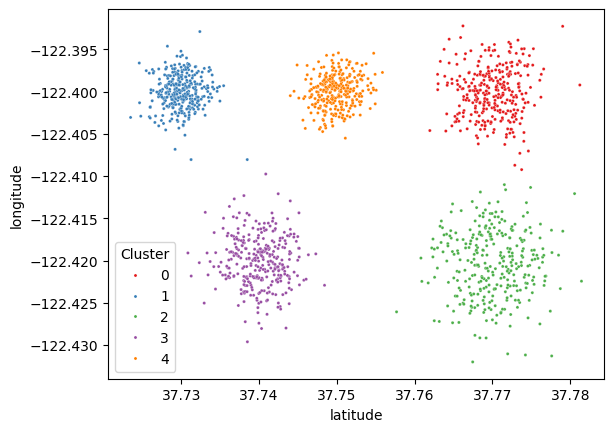

In [8]:
sns.scatterplot(x=imputed_train_coordinates["latitude"], y=imputed_train_coordinates["longitude"], hue=clustered_train_coordinates["Cluster"], palette="Set1", s=5)

<Axes: xlabel='latitude', ylabel='longitude'>

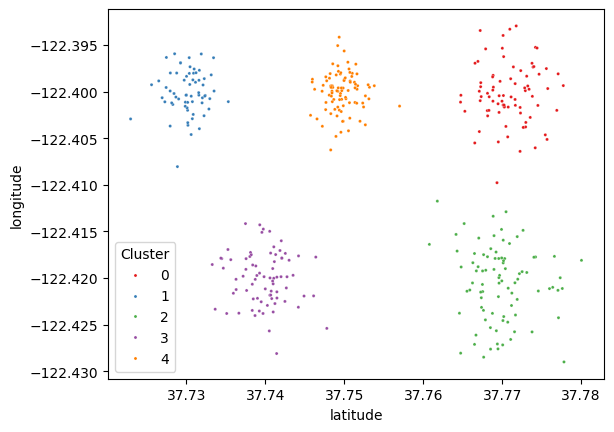

In [9]:
sns.scatterplot(x=imputed_test_coordinates["latitude"], y=imputed_test_coordinates["longitude"], hue=clustered_test_coordinates["Cluster"], palette="Set1", s=5)

# K-Means Transformer-Klasse definieren

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings("ignore")

class ClusterCreator(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=0)

    def fit(self, X, y=None):
        self.kmeans.fit(X)
        return self

    def transform(self, X):
        clusters = self.kmeans.predict(X)
        return clusters.reshape(-1, 1)

In [11]:
cluster_creator = ClusterCreator(n_clusters=5)


clustered_train_coordinates_2 = pd.DataFrame(cluster_creator.fit_transform(imputed_train_coordinates), columns=["Cluster"], index=train_coordinates.index)
clustered_test_coordinates_2 = pd.DataFrame(cluster_creator.transform(imputed_test_coordinates), columns=["Cluster"], index=test_coordinates.index)

clustered_train_coordinates_2

,Cluster
743,0
159,3
1165,0
318,0
924,4
...,...
835,0
1216,1
1653,3
559,1


# Data Pipeline erstellen

In [12]:
train_coordinates

,latitude,longitude
743,37.768299,-122.402863
159,37.739622,-122.419379
1165,37.774024,-122.401898
318,37.766098,-122.399665
924,37.750598,-122.398895
...,...,...
835,37.773279,-122.393901
1216,37.730334,-122.403531
1653,37.743014,-122.420489
559,37.730594,-122.398259


In [13]:
from sklearn.pipeline import Pipeline

coordinates_pipeline = Pipeline(steps=[
    ("imputer", num_imputer),
    ("clusterer", cluster_creator)
])


clustered_train_coordinates_final = pd.DataFrame(coordinates_pipeline.fit_transform(train_coordinates), columns=["Cluster"], index=train_coordinates.index)
clustered_test_coordinates_final = pd.DataFrame(coordinates_pipeline.transform(test_coordinates), columns=["Cluster"], index=test_coordinates.index)

clustered_train_coordinates_final

,Cluster
743,0
159,3
1165,0
318,0
924,4
...,...
835,0
1216,1
1653,3
559,1


In [14]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

coordinates_pipeline = Pipeline(steps=[
    ("imputer", num_imputer),
    ("scaler", standard_scaler),
    ("clusterer", cluster_creator)
])

clustered_train_coordinates_final = pd.DataFrame(coordinates_pipeline.fit_transform(train_coordinates), columns=["Cluster"], index=train_coordinates.index)
clustered_test_coordinates_final = pd.DataFrame(coordinates_pipeline.transform(test_coordinates), columns=["Cluster"], index=test_coordinates.index)

clustered_train_coordinates_final

,Cluster
743,0
159,1
1165,0
318,0
924,4
...,...
835,0
1216,2
1653,1
559,2


<Axes: xlabel='latitude', ylabel='longitude'>

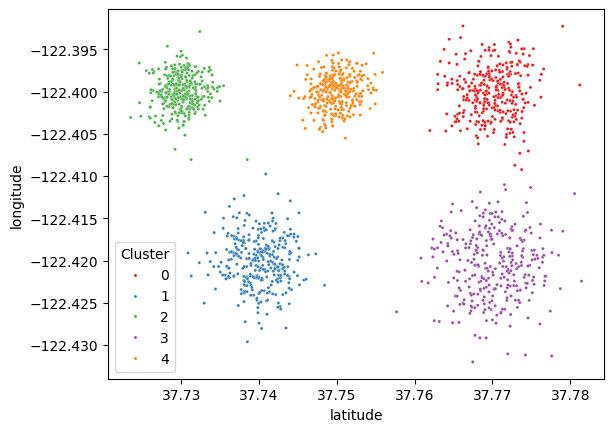

In [15]:
sns.scatterplot(x=imputed_train_coordinates["latitude"], y=imputed_train_coordinates["longitude"], hue=clustered_train_coordinates_final["Cluster"], palette="Set1", s=5)

<Axes: xlabel='latitude', ylabel='longitude'>

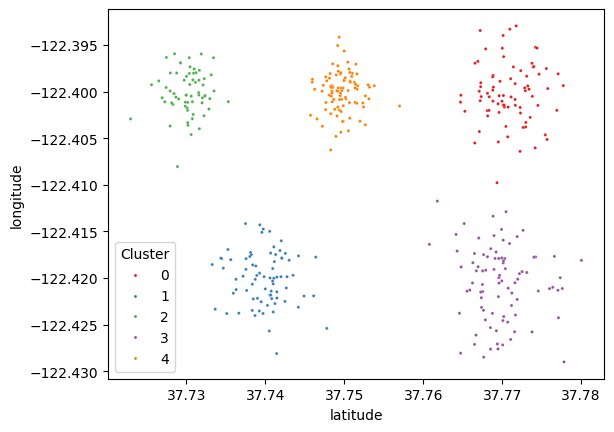

In [16]:
sns.scatterplot(x=imputed_test_coordinates["latitude"], y=imputed_test_coordinates["longitude"], hue=clustered_test_coordinates_final["Cluster"], palette="Set1", s=5)